In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import albumentations as albu

import torch
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset
from torch import nn
from pytorch_lightning import LightningModule
import segmentation_models_pytorch as smp

import glob
from PIL import Image

In [2]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [3]:
PATH_IMAGE =  'image_processing/data/image/'
PATH_MASK =  'image_processing/data/mask/'

list_mask = os.listdir(PATH_MASK)
list_img = os.listdir(PATH_IMAGE)

In [4]:
def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.PadIfNeeded(640, 640),
        albu.RandomCrop(height=640, width=640, always_apply=True),
    ]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    if len(x.shape) == 3:
        return x.transpose(2, 0, 1).astype('float32') / 255.
    else:
        return x.astype('float32') / 255.


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

In [5]:
class Dataset(BaseDataset):
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    CLASSES = ['unlabelled', 'building']
    
    def __init__(
            self, 
            images_list, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = images_list
        self.images_fps = [os.path.join(PATH_IMAGE, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(PATH_MASK, image_id) for image_id in self.ids]
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], cv2.IMREAD_GRAYSCALE)
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)

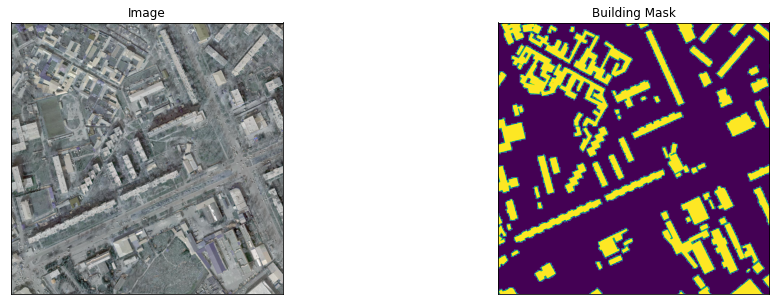

In [6]:
dataset = Dataset(list_img, classes=['building'])

image, mask = dataset[6] # get some sample
visualize(
    image=image, 
    building_mask=mask.squeeze(),
)

In [7]:
ENCODER = 'timm-efficientnet-b5'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['building']
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multicalss segmentation
DEVICE = 'cuda'

model = smp.DeepLabV3Plus(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [8]:
eval_dataset = Dataset(
    list_img, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

In [9]:
eval_loader = DataLoader(eval_dataset, batch_size=4, shuffle=False, num_workers=4)

In [10]:
loss = smp.losses.DiceLoss(mode='binary')
class SemSegment(LightningModule):
    def __init__(
        self,
        lr: float = 0.001,
        num_classes: int = 1,
        bilinear: bool = False,
    ):
        super().__init__()

        self.bilinear = bilinear
        self.lr = lr
        self.net = model
        self.loss = loss
        self.metric = smp.metrics.iou_score
        self.stats = smp.metrics.get_stats

    def forward(self, x):
        return self.net(x)

    def training_step(self, batch, batch_nb):
        img, mask = batch
        out = self(img.float())
        loss_train_dice = self.loss(out.squeeze(1), mask.float())

        tp, fp, fn, tn = self.stats(out.squeeze(1), mask.detach().int(), mode='binary', threshold=0.5)
        metric = self.metric(tp, fp, fn, tn, reduction="micro")
        # Логи тренировочных шагов для tensorboard
        self.log('train_dice_step', loss_train_dice, on_step=True, )

        return {"loss": loss_train_dice, "log": metric.detach(), "progress_bar": loss_train_dice.detach()}

    def validation_step(self, batch, batch_idx):
        img, mask = batch
        out = self(img.float())
        tp, fp, fn, tn = self.stats(out.squeeze(1), mask.detach().int(), mode='binary', threshold=0.5)
        metric = self.metric(tp, fp, fn, tn, reduction="micro")
        # Логи валидационных шагов для tensorboard
        self.log('val_loss_step', metric, on_step=True)

        return {"val_loss": metric}


    def validation_epoch_end(self, outputs):
        loss_val = torch.stack([x["val_loss"] for x in outputs]).mean()
        log_dict = {"val_loss": loss_val.detach()}
        # Логи валидационных эпох для tensorboard
        self.log('val_epoch_total_step', log_dict['val_loss'], on_epoch=True)

        return log_dict

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.net.parameters(), lr=self.lr)
        scheduler = {
            'scheduler': torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min'),
            'monitor' : 'train_dice_step',
        }
        return {
                "optimizer": optimizer,
                "lr_scheduler": scheduler,
                }

In [11]:
model = SemSegment().load_from_checkpoint('diplab.ckpt')

In [12]:
images, masks = next(iter(eval_loader))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


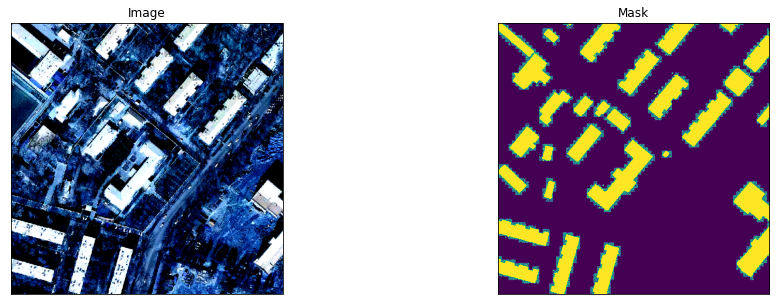

In [13]:
visualize(image=images[1].permute(1,2,0)*255, mask=masks[1])

In [14]:
out = model(images)
out = out.squeeze(1) 
out.shape

torch.Size([4, 640, 640])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


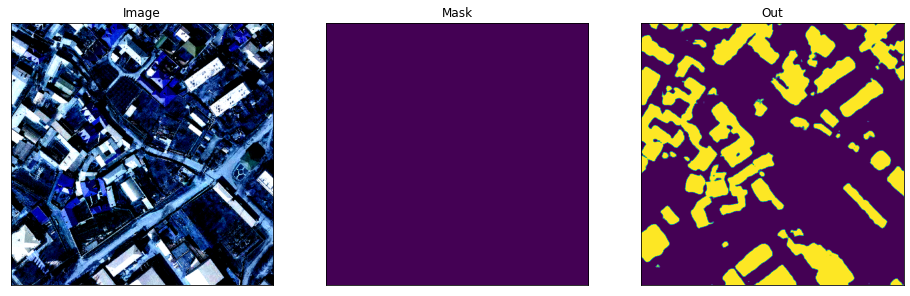

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


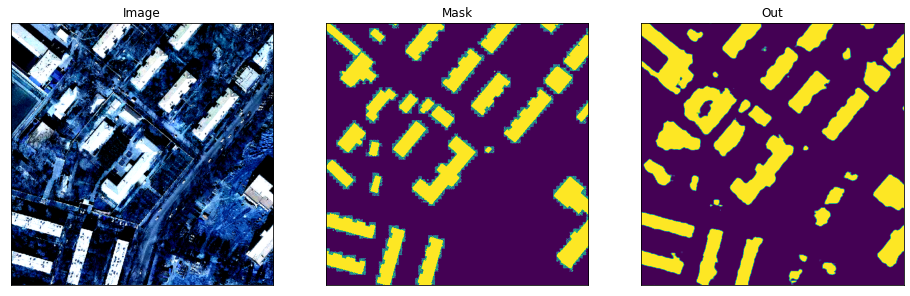

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


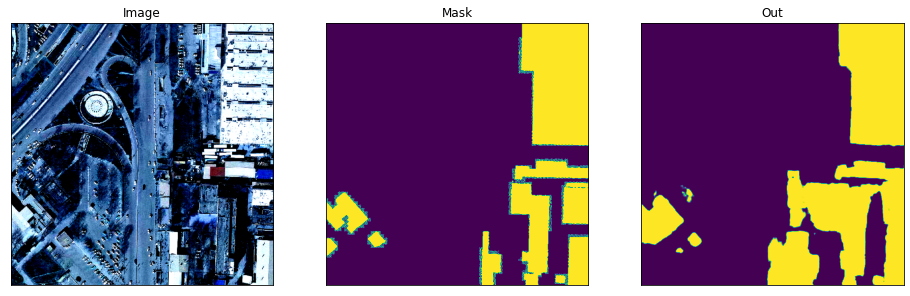

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


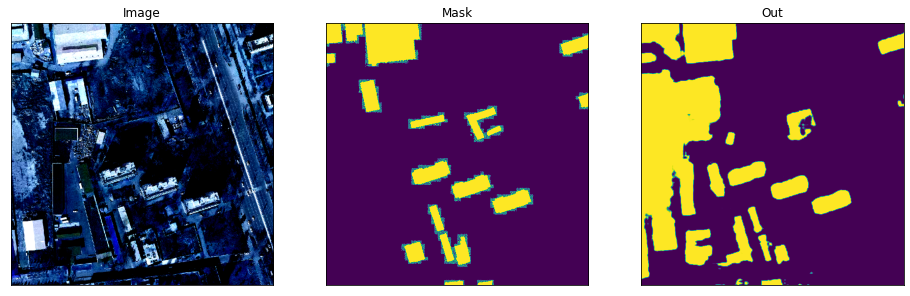

In [18]:
for i in range(4):
    visualize(image=images[i].permute(1,2,0)*255, mask=masks[i], out = out[i].detach().numpy())